# SELF-SUPERVISED DENOISING: PART TWO
### Authors: Claire Birnie and Sixiu Liu, KAUST

Author websites: 
- https://cebirnie92.github.io/ 
- https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))

## Tutorial Overview

On completion of this tutorial you will have learnt how to adapt your previously wrote blind-spot denoising procedure to handle noise that has some temporal relationship. In this instance, we imitate this using bandpassed noise. At the end of the tutorial, you will have the opportunity to denoise a field dataset often used for benchmarking random noise suppression procedures.

### Recap
As a reminder, the networks are trained in a self-supervised manner, i.e., the training data is the same as the inference data with no labels required! This tutorial is the second in the second in our self-supervised denoising series. For a recap on the methodology and the denoising performance under idealistic scenarios, review Tutorial One.

***

In [1]:
# Import necessary packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Our unet functions just to speed things up
from unet import UNet
from tutorial_utils import regular_patching_2D, add_bandlimited_noise, weights_init, set_seed, make_data_loader

In [2]:
cmap='RdBu'
vmin = -0.25
vmax = 0.25

set_seed(42) # For reproducibility set random, numpy and torch seeds

True

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the public data folder: https://exrcsdrive.kaust.edu.sa/exrcsdrive/index.php/s/vjjry6BZ3n3Ewei

with password: `kaust`

If the folder is no longer public, this is likely due to expired rights. Please email: cebirnie[at]kaust.edu.sa to request access.

In [3]:
d = np.load("./data/Hess_PostStackSection.npy")
print(d.shape)

# Plot to see the noise free data
plt.imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)

(196, 452)


### Add noise

In [5]:
noisydata, _ = add_bandlimited_noise(d, sc=0.1)

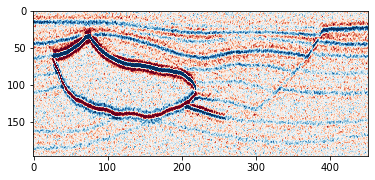

In [6]:
# plot to see the noisy data
plt.imshow(noisydata, cmap=cmap, vmin=vmin, vmax=vmax)

### Patch data

In [7]:
noisy_patches = regular_patching_2D(noisydata, 
                                    patchsize=[32, 32], 
                                    step=[6,6])

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

Extracting 1960 patches


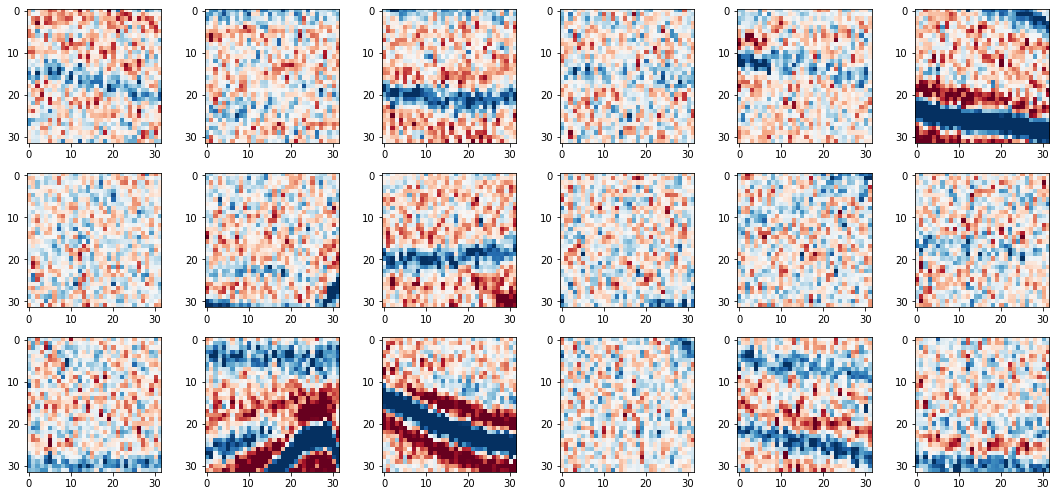

In [8]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

***

# Step Two - Blindspot corruption of training data

In [9]:
# To do: Create a function that randomly selects and corrupts pixels following N2V methodology
def multi_active_pixels(patch, 
                        num_activepixels, 
                        neighbourhood_radius=5,
                       ):

    n_rad = neighbourhood_radius  # descriptive variable name was a little long

    # Select multiple locations for active pixels
    idx_aps = np.random.randint(0, patch.shape[0], num_activepixels)
    idy_aps = np.random.randint(0, patch.shape[1], num_activepixels)

    # For each active pixel compute shift for finding neighbouring pixel and find pixel
    x_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    y_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    
    # OPTIONAL: don't allow replacement with itself
    for i in range(len(x_neigh_shft)):
        if x_neigh_shft[i] == 0 and y_neigh_shft[i] == 0:
            # This means its replacing itself with itself...not good!
            shft_options = np.trim_zeros(np.arange(-n_rad // 2 + 1, n_rad // 2 + 1))
            x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)

    # Find x and y locations of neighbours for the replacement
    idx_neigh = idx_aps + x_neigh_shft
    idy_neigh = idy_aps + y_neigh_shft

    # Make sure neighbouring pixels within window
    idx_neigh = idx_neigh + (idx_neigh < 0) * patch.shape[0] - (idx_neigh >= patch.shape[0]) * patch.shape[0]
    idy_neigh = idy_neigh + (idy_neigh < 0) * patch.shape[1] - (idy_neigh >= patch.shape[1]) * patch.shape[1]
    
    # combine x and y coordinates for active pixels and neighbouring pixels
    id_aps = (idx_aps, idy_aps)
    id_neigh = (idx_neigh, idy_neigh)
    
    # Make mask and corrupted patch
    mask = np.ones_like(patch)
    cp_ptch = patch.copy()
    mask[id_aps] = 0.
    cp_ptch[id_aps] = patch[id_neigh]

    return cp_ptch, mask


In [10]:
# TO DO: Select the number of active pixels

# Choose the percent of active pixels per patch (in original N2V ranges from 0.5-2%)
perc_active = 33

# Compute the total number of pixels within a patch
total_num_pixels = noisy_patches[0].shape[0]*noisy_patches[0].shape[1]
# Compute the number that should be active pixels based on the choosen percentage
num_activepixels = int(np.floor((total_num_pixels/100) * perc_active))

In [11]:
# TO DO: Check the corruption function works
crpt_patch, mask = multi_active_pixels(noisy_patches[0], 
                                       num_activepixels=num_activepixels, 
                                       neighbourhood_radius=5, 
                                      )

Text(0.5, 1.0, 'Corruption Mask')

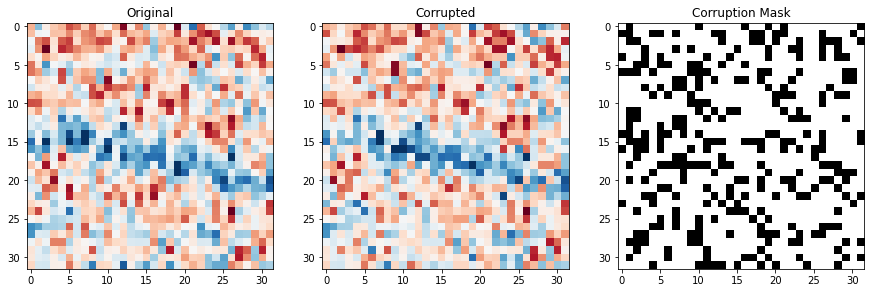

In [12]:
fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(noisy_patches[0], cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(crpt_patch, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(mask, cmap='binary_r')

axs[0].set_title('Original')
axs[1].set_title('Corrupted')
axs[2].set_title('Corruption Mask')

***

# Step three - Set up network

In [13]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA Tesla V100-SXM2-32GB


In [14]:
# Build UNet
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)

network = network.apply(weights_init) 

/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/tutorial_utils.py:117: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/tutorial_utils.py:118: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


In [15]:
# Network initialisation steps
lr = 0.0005
criterion = nn.L1Loss()
optim = torch.optim.Adam(network.parameters(), lr=lr)

***

# Step four - training

In [16]:
# Choose the number of epochs
n_epochs = 20

# Choose number of training samples
n_training = 1280
n_test = 256
batch_size = 128
    
# Initial train and val 
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

In [17]:
# Training Function
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    
    model.train()
    accuracy = 0
    loss = 0

    for dl in tqdm(data_loader):
        X, y, mask = dl[0], dl[1], dl[2]
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        optimizer.zero_grad()
        yprob = model(X)

        # TO DO: Compute loss function only at masked locations
        # (Hint: only one line required)
        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        
        ls.backward()
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        loss += ls.item()
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))
        
    loss /= len(data_loader)
    accuracy /= len(data_loader)   

    return loss, accuracy

In [18]:
# Validation Function
def n2v_evaluate(model,
                 criterion, 
                 optimizer, 
                 data_loader, 
                 device):
    
    model.train()
    accuracy = 0
    loss = 0

    for dl in tqdm(data_loader):
        X, y, mask = dl[0], dl[1], dl[2]
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        optimizer.zero_grad()
        yprob = model(X)

        with torch.no_grad():
            
            # TO DO: Compute loss function only at masked locations
            # (Hint: only one line required)
            ls = criterion(yprob * (1 - mask), y * (1 - mask))
     
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        loss += ls.item()
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))
        
    loss /= len(data_loader)
    accuracy /= len(data_loader)

    return loss, accuracy

In [ ]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               num_activepixels=num_activepixels, 
                                                               neighbourhood_radius=5, 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



100%|██████████| 2/2 [00:00<00:00, 21.68it/s]


Epoch 0, 
    Training Loss 0.0209,     Training Accuracy 0.0980, 
    Test Loss 0.0181,     Test Accuracy 0.0827 


100%|██████████| 2/2 [00:00<00:00, 21.92it/s]


Epoch 1, 
    Training Loss 0.0170,     Training Accuracy 0.0783, 
    Test Loss 0.0161,     Test Accuracy 0.0765 


100%|██████████| 2/2 [00:00<00:00, 22.67it/s]


Epoch 2, 
    Training Loss 0.0159,     Training Accuracy 0.0765, 
    Test Loss 0.0155,     Test Accuracy 0.0744 


100%|██████████| 2/2 [00:00<00:00, 22.26it/s]


Epoch 3, 
    Training Loss 0.0155,     Training Accuracy 0.0742, 
    Test Loss 0.0153,     Test Accuracy 0.0734 


100%|██████████| 2/2 [00:00<00:00, 22.71it/s]


Epoch 4, 
    Training Loss 0.0153,     Training Accuracy 0.0738, 
    Test Loss 0.0150,     Test Accuracy 0.0733 


100%|██████████| 2/2 [00:00<00:00, 22.29it/s]


Epoch 5, 
    Training Loss 0.0152,     Training Accuracy 0.0737, 
    Test Loss 0.0152,     Test Accuracy 0.0729 


100%|██████████| 2/2 [00:00<00:00, 22.71it/s]


Epoch 6, 
    Training Loss 0.0151,     Training Accuracy 0.0729, 
    Test Loss 0.0150,     Test Accuracy 0.0723 


100%|██████████| 2/2 [00:00<00:00, 22.65it/s]


Epoch 7, 
    Training Loss 0.0151,     Training Accuracy 0.0726, 
    Test Loss 0.0150,     Test Accuracy 0.0721 


100%|██████████| 2/2 [00:00<00:00, 22.86it/s]


Epoch 8, 
    Training Loss 0.0151,     Training Accuracy 0.0725, 
    Test Loss 0.0150,     Test Accuracy 0.0718 


100%|██████████| 2/2 [00:00<00:00, 22.65it/s]


Epoch 9, 
    Training Loss 0.0151,     Training Accuracy 0.0722, 
    Test Loss 0.0150,     Test Accuracy 0.0722 


100%|██████████| 2/2 [00:00<00:00, 22.17it/s]


Epoch 10, 
    Training Loss 0.0150,     Training Accuracy 0.0717, 
    Test Loss 0.0149,     Test Accuracy 0.0711 


100%|██████████| 2/2 [00:00<00:00, 22.63it/s]


Epoch 11, 
    Training Loss 0.0150,     Training Accuracy 0.0719, 
    Test Loss 0.0149,     Test Accuracy 0.0718 


100%|██████████| 2/2 [00:00<00:00, 22.63it/s]


Epoch 12, 
    Training Loss 0.0149,     Training Accuracy 0.0715, 
    Test Loss 0.0149,     Test Accuracy 0.0707 


100%|██████████| 2/2 [00:00<00:00, 22.15it/s]


Epoch 13, 
    Training Loss 0.0149,     Training Accuracy 0.0712, 
    Test Loss 0.0149,     Test Accuracy 0.0711 


100%|██████████| 2/2 [00:00<00:00, 22.54it/s]


Epoch 14, 
    Training Loss 0.0148,     Training Accuracy 0.0710, 
    Test Loss 0.0147,     Test Accuracy 0.0705 


100%|██████████| 2/2 [00:00<00:00, 22.58it/s]


Epoch 15, 
    Training Loss 0.0149,     Training Accuracy 0.0712, 
    Test Loss 0.0147,     Test Accuracy 0.0703 


 30%|███       | 3/10 [00:00<00:00,  9.64it/s]

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,4))

axs[0].plot(train_accuracy_history, 'r', lw=2, label='train')
axs[0].plot(test_accuracy_history, 'k', lw=2, label='validation')
axs[0].set_title('RMSE', size=16)
axs[0].set_ylabel('RMSE', size=12)

axs[1].plot(train_loss_history, 'r', lw=2, label='train')
axs[1].plot(test_loss_history, 'k', lw=2, label='validation')
axs[1].set_title('Loss', size=16)
axs[1].set_ylabel('Loss', size=12)


for ax in axs:
    ax.legend()
    ax.set_xlabel('# Epochs', size=12)
fig.tight_layout()

***

## Step five - apply trained model

In [ ]:
# Make a new noisy realisation so it's different from the training set
testdata, _ = add_bandlimited_noise(d, sc=0.1)

In [ ]:
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()
test_prediction = network(torch_testdata.to(device))
test_pred = test_prediction.detach().cpu().numpy().squeeze()

In [ ]:
fig,axs = plt.subplots(1,4,figsize=[15,4])
axs[0].imshow(d[:196,:452], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(testdata, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[3].imshow(testdata-test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_title('Clean')
axs[1].set_title('Noisy')
axs[2].set_title('Denoised')
axs[3].set_title('Noise Removed')

fig.tight_layout()

***

# PART TWO : APPLYING TO FIELD DATA

(700, 310)


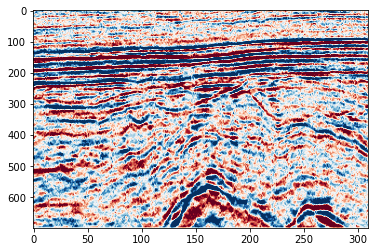

In [26]:
d = np.load("./data/FieldExample_RandomNoise.npy")
print(d.shape)
# Plot to see the noise free data
plt.imshow(d, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')